<a href="https://colab.research.google.com/github/afranavas/PhD_Algorithm_for_Antenna_Problem/blob/main/ANN_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import scipy.io as sio

print("Upload the training data file:")
training_data_file = files.upload()
print("Upload the testing data file:")
testing_data_file = files.upload()


Upload the training data file:


Saving Training_Data.mat to Training_Data.mat
Upload the testing data file:


Saving Real_Test_Data.mat to Real_Test_Data.mat


In [1]:
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [21]:
train_data_path = 'Training_Data.mat'
test_data_path = 'Real_Test_Data.mat'

def load_data(path, variable_name):
    data = sio.loadmat(path)
    return data[variable_name]

train_data = load_data(train_data_path, 'candidates')
train_responses = load_data(train_data_path, 'responses')
test_data = load_data(test_data_path, 'real_test_candidates')
test_responses = load_data(test_data_path, 'real_test_responses')

print("Training Data Type:", type(train_data))
print("Training Responses Type:", type(train_responses))
print("Test Data Type:", type(test_data))
print("Test Responses Type:", type(test_responses))

Training Data Type: <class 'numpy.ndarray'>
Training Responses Type: <class 'numpy.ndarray'>
Test Data Type: <class 'numpy.ndarray'>
Test Responses Type: <class 'numpy.ndarray'>


In [39]:
train_data = np.array(train_data, dtype=np.float32).reshape(-1, 3)
train_responses = np.array(train_responses, dtype=np.float32).reshape(-1, 1)
test_data = np.array(test_data, dtype=np.float32).reshape(-1, 3)
test_responses = np.array(test_responses, dtype=np.float32).reshape(-1, 1)

print("Training Data Shape:", train_data.shape)
print("Training Responses Shape:", train_responses.shape)
print("Test Data Shape:", test_data.shape)
print("Test Responses Shape:", test_responses.shape)

Training Data Shape: (64, 3)
Training Responses Shape: (192192, 1)
Test Data Shape: (36, 3)
Test Responses Shape: (108108, 1)


In [52]:
print(f"Training Data Shape: {train_data_tensor.shape}")
print(f"Training Responses Shape: {train_responses_tensor.shape}")
print(f"Test Data Shape: {test_data_tensor.shape}")
print(f"Test Responses Shape: {test_responses_tensor.shape}")

Training Data Shape: torch.Size([64, 3])
Training Responses Shape: torch.Size([192192])
Test Data Shape: torch.Size([36, 3])
Test Responses Shape: torch.Size([108108])


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_responses_tensor = torch.tensor(train_responses, dtype=torch.float32).flatten()
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_responses_tensor = torch.tensor(test_responses, dtype=torch.float32).flatten()

input_size = train_data_tensor.shape[1]
hidden_size = 128
output_size = 1  # Single output for S11 parameter
ann_model = ANNModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)


In [60]:
num_epochs = 1000
batch_size = 64  # Define a batch size

for epoch in range(num_epochs):
    for i in range(0, train_data_tensor.size(0), batch_size):
        batch_data = train_data_tensor[i: i + batch_size]
        batch_responses = train_responses_tensor[i: i + batch_size]

        ann_model.train()
        outputs = ann_model(batch_data)
        loss = criterion(outputs, batch_responses.unsqueeze(1))  # Calculate loss for the batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 5.5568
Epoch [200/1000], Loss: 5.4124
Epoch [300/1000], Loss: 5.2879
Epoch [400/1000], Loss: 5.2103
Epoch [500/1000], Loss: 5.1661
Epoch [600/1000], Loss: 5.1291
Epoch [700/1000], Loss: 5.0906
Epoch [800/1000], Loss: 5.0497
Epoch [900/1000], Loss: 5.0008
Epoch [1000/1000], Loss: 4.9532


In [63]:
ann_model.eval()
with torch.no_grad():
    train_features = ann_model(train_data_tensor).numpy()
    test_features = ann_model(test_data_tensor).numpy()

print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")



Shape of train_features: (64, 1)
Shape of test_features: (36, 1)


In [64]:
if train_features.shape[0] != train_data_tensor.shape[0]:
    raise ValueError(f"Mismatch in training features and data samples: {train_features.shape[0]} vs {train_data_tensor.shape[0]}")
if test_features.shape[0] != test_data_tensor.shape[0]:
    raise ValueError(f"Mismatch in test features and data samples: {test_features.shape[0]} vs {test_data_tensor.shape[0]}")


In [65]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

train_responses_flat = train_responses_tensor.numpy().flatten()[:64]
test_responses_flat = test_responses_tensor.numpy().flatten()[:36]

print(f"Shape of train_responses_flat: {train_responses_flat.shape}")
print(f"Shape of test_responses_flat: {test_responses_flat.shape}")

Shape of train_responses_flat: (64,)
Shape of test_responses_flat: (36,)


In [66]:
if train_features.shape[0] != train_responses_flat.shape[0]:
    raise ValueError(f"Inconsistent number of samples in training data: {train_features.shape[0]} vs {train_responses_flat.shape[0]}")
if test_features.shape[0] != test_responses_flat.shape[0]:
    raise ValueError(f"Inconsistent number of samples in test data: {test_features.shape[0]} vs {test_responses_flat.shape[0]}")


In [67]:
svm_model = SVR(kernel='rbf')
svm_model.fit(train_features, train_responses_flat)
predicted_responses = svm_model.predict(test_features)

print("Prediction completed successfully.")

Prediction completed successfully.


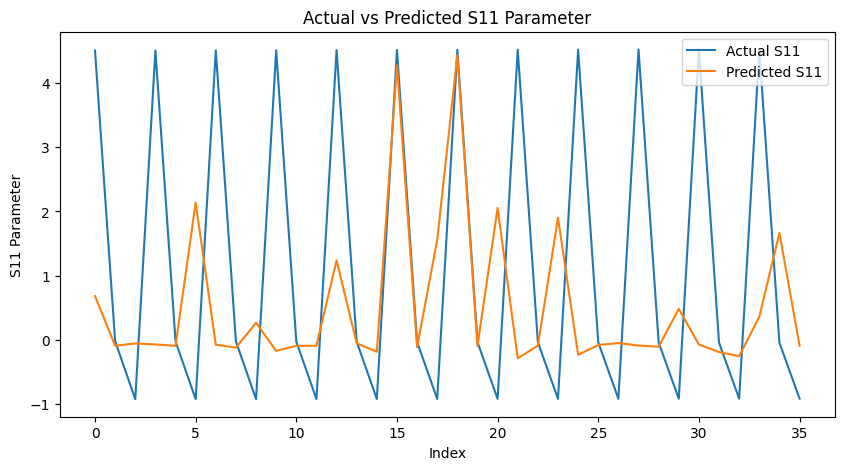

Mean Squared Error: 6.57128744641818


In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 5))
plt.plot(test_responses_flat, label='Actual S11')
plt.plot(predicted_responses, label='Predicted S11')
plt.xlabel('Index')
plt.ylabel('S11 Parameter')
plt.title('Actual vs Predicted S11 Parameter')
plt.legend()
plt.show()

mse = mean_squared_error(test_responses_flat, predicted_responses)
print(f'Mean Squared Error: {mse}')
